In [26]:
!python -V


Python 3.9.13


In [27]:
import pandas as pd

In [28]:
import pickle

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [31]:
pwd

'/home/shravan/personal_projects/datatalks/mlopszoomcamp/mlops-zoomcamp/01-intro'

In [56]:
df = pd.read_parquet('/home/shravan/personal_projects/datatalks/mlopszoomcamp/data/yellow_tripdata_2022-01.parquet')   
print(df.shape)
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.std()

(2463931, 19)


/tmp/ipykernel_5468/2557887701.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.std()


VendorID                                   0.502137
tpep_pickup_datetime     14 days 07:12:05.644016136
tpep_dropoff_datetime    14 days 07:11:17.325123812
passenger_count                            0.982969
trip_distance                            547.871404
RatecodeID                                 5.917573
PULocationID                              65.468057
DOLocationID                              70.790159
payment_type                               0.500178
fare_amount                              255.814887
extra                                      1.236226
mta_tax                                    0.082916
tip_amount                                 2.830698
tolls_amount                               1.680538
improvement_surcharge                      0.043747
total_amount                             255.964089
congestion_surcharge                       0.743204
airport_fee                                0.312555
duration                                  46.445305
dtype: objec

In [57]:
df = df[(df.duration >= 1) & (df.duration <= 60)]
df.shape

(2421440, 20)

In [58]:
2421440/2463931

0.9827547930522406

In [60]:
df = pd.read_parquet('/home/shravan/personal_projects/datatalks/mlopszoomcamp/data/yellow_tripdata_2022-01.parquet')   
print(df.columns)

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')


In [62]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

print(X_train.shape)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

(2421440, 516)


6.986335020300458

/tmp/ipykernel_5468/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_5468/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


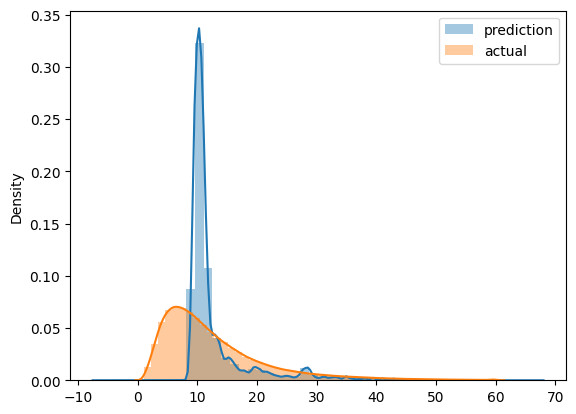

In [63]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [64]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [65]:
df_train = read_dataframe('/home/shravan/personal_projects/datatalks/mlopszoomcamp/data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('/home/shravan/personal_projects/datatalks/mlopszoomcamp/data/yellow_tripdata_2022-02.parquet')

In [66]:
len(df_train), len(df_val)

(2421440, 2918187)

In [67]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [68]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [69]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [70]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.4149072913703815

In [71]:
with open('/home/shravan/personal_projects/datatalks/mlopszoomcamp/models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [72]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.374921127169834

In [73]:
X_train.shape

(2421440, 20667)